**Author:** Rui ZHANG 

**Department:** EIT

**E-mail:** cheryl_zhangrui@163.com / rui.zhang1@etu.unice.fr

-----------------------------------------------------------------------------
**30/03/2020**

Submission 2, corresponding to Task 3~5

-----------------------------------------------------------------------------
**26/04/2020**

Submission 3, corresponding to Task 6~8.

Made some revisions in the main class App in Chapter 3 for composing the dataset (saving images and writing the txt file, as Task 6 requires); the App class is also revised with two modes: data collecting mode and testing mode. By setting special FLAGs it is compatible with both tasks. Details can be seen in corresponding chapters.

Corner cases are considered to make the algorithm more robust and correct.

Chapter 4 is newly added for real-time testing, for Task 7 and 8.

-----------------------------------------------------------------------------
**12/05/2020**

Submission4, corresponding to Task 9.

Add chapter 5 and small changes in Main class to use vgg model.

# **0 Readme**



This notebook gives the example of using the laptop camera and opencv-python CAMShift (continuously adaptive mean shift) algorithm to detect and track the hand. Then the detected hand images are saved and an MLP is trained for the recognition of the hand image. The notebook is structured as follows:

1. Preparation
2. Helper Functions
3. Hand Detection using CAMShift
4. Training and Test of MLP
5. **Transfer learning with vgg19**

The explanation of the method, steps and result analysis will follow the title of that part.

For former submissions, to run the code, please run the cells in sequence and then the corresponding demos. There will be an explanation of parameters needed in the demo just before that demo.

**For submission 4 task 9, please run the cells in chapter 1, 2, 3 (not including the demo cells) and chapter 5 with the demos.**


# **1 Preparation**

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
from PIL import Image
import io
import cv2
import os
import random

from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import glob
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks.callbacks import Callback
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import model_from_json


DRIVE_MOUNTED = False

If **save pictures** to drive, mount drive use the following cell:

In [0]:
from google.colab import drive
drive.mount("/content/drive/")
DRIVE_MOUNTED = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# **2 Helper Functions**

### **2.1 Camera calling and display**

Javascript code to call the camera and display the video and image in Google Coloab (from teacher)

In [0]:
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);

      transfer = document.createElement('div');
      transfer.id = "transfer";
      transfer.style.color = "none";
      document.body.appendChild(transfer);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x



### **2.2 Image saving control functions**

JavaScript codes to detect the clickon event, decide whether to save an image and input the letter of the filename.

In [0]:
def ClickTracker():
  js2 = Javascript('''

    // Add a click button on the canvas to manually save the image
    async function JSSaveImage() {
      button = document.createElement('button');
      button.setAttribute('content', 'Click to Save Image');
      button.setAttribute('onclick', 'savejs()');
      button.innerHTML = 'Click to Save Image';
      
      input = document.createElement('input')
      input.id = "inputLetter"

      document.body.appendChild(input);
      document.body.appendChild(button);
    } 

    // When we click the button, the innerHTML of element transfer will change to "save it", as a message for saving the image
    function  savejs() {
      document.getElementById("transfer").innerHTML = "save it";
    }

    // In each iteration, the checkForSave function is called to check the message of "transfer", as a FLAG to decide whether to
    // save the image
    async function  checkForSave() {
      decide = document.getElementById("transfer").innerHTML;
      document.getElementById("transfer").innerHTML = "checked";
      if( decide == "save it") {
          return true;
      }
      else {
          return false;
      }
    }

    async function getLetter() {
       decide = document.getElementById("inputLetter").value;
       return await decide
    }

    ''')
  display(js2)

### **2.3 Other helper functions**

Includes the following functions:

**clock()**: timing function

**draw_string(dst, target, s)**: function to put a string in the image, to show the detection time

**detect(img, cascade)**: use the classifier to detect face and return the result

In [0]:
def clock():
  """
  Get the time (calculated by clock cycles / clock frequency).
  From opencv examples common.py.
  :return: Present timestamp (in seconds).
  """
  return cv2.getTickCount() / cv2.getTickFrequency()


def draw_str(dst, target, s):
  """
  Put a string of text on the given image.
  From opencv examples common.py.
  :param dst: string position
  :param target: the image to be put text on
  :param s: the string to be shown
  :return: None
  """
  x, y = target
  # Strings with 1 pixel translation in x and y and different colors to make the text more obvious to be seen
  cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
  cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


def detect(img, cascade):
  """
  Detect the face in the input image using the cascade detector.
  From opencv examples facedetect.py.
  :param img: the input image to be detected
  :param cascade: the classifier
  :return: the detected faces, in a list of rectangles [x0, y0, w, h]
  """
  # Detect faces of different size in the input image, reduce the image size by 30% when constructing the image 
  # pyramid, set the minimum face to be detected at size 30x30
  rects = cascade.detectMultiScale(img, scaleFactor=1.3, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  # No face detected in the input image
  if len(rects) == 0:
    return []
  # The detected result is given as [x0, y0, w, h]
  return rects

# **3 Hand Detection using CAMshift**

The hand detection using CAMshift method. We don't have a trained classifier for hands, but we have a face detector on hand, so we can use the CAMshift algorithm to track areas which have similar color as our faces, that is, our hands.

**Steps:**

The process of the hand detection: 

1. use the Adaboost face detector in opencv to detect the face area
2. initialize the color histogram using the detected face area
3. track the face using CAMShift
4. erase the face in the probability map
5. detect and track the hand in the remaining probability map using CAMshift
6. save the hand image
7. if the face is lost while tracking it (or meet some problem, like a negative value in the tracking window), reset the detection by going back to step 1

Detailed explanations of the process are within the code.

**Result:**

I draw the detected face and hand using CAMShift on the displayed images, where the face area is in red ellipse, and the hand is in blue.

Then detection and tracking time of hand using CAMShift method is reduced greatly (around 1ms) compared to the former adaboost classifier, but as a detection method which mainly takes use of the color information of the object, sometimes the CAMShift detection is easily to be obstructed by the background noise or areas with similar color as skin.

**Revision on 22/04/2020 :**

1. Revise the main loop in App.run() method, to make it compatible with both hand data collection and real-time testing.

2. Consider special cases to make the algorithm more robust. When a face is not detected (e.g. incomplete face at corners, or no face in the image), the algorithm will keep detecting a face in the whole image until a face is detected (which has been done last time); when no hand is detected, the tracking window will be reset as the whole image; when the hand is at the corners, boundary conditions will be checked.

## **3.1 Main class**

In [0]:
class App():
    """
    The hand tracking class using camshift. The framework is from opencv example camshift.py.
    """
    def __init__(self, SHOW_BACKPROJ, SAVE_DRIVE, TEST_PHASE, TEST_VGG=False, img_root_dir=None, datafile_dir=None, model=None):
        """
        Class initialization.
        :param img_root_dir: the root directory of saving the images.
        :param datafile_dir: the directory of the txt file which saves the 16x16 image.
        :param SHOW_BACKPROJ: to show the backprojection 
        :param SAVE_DRIVE: a flag to save images
        :param TEST_PHASE: a flag to do real-time recognition test
        :param TEST_VGG: a flag to indicate if testing with transfer learning
        """
        self.selection = None        # the initial detected rectangle of the face.
        self.track_window = None       # the track window of face obtained by camshift
        self.track_window_hand = None    # the track window of hand obtained by camshift
        self.show_backproj = SHOW_BACKPROJ
        self.SAVE_DRIVE = SAVE_DRIVE
        self.TEST_PHASE = TEST_PHASE
        self.TEST_VGG = TEST_VGG

        # create a camera view
        VideoCapture()
        eval_js('create()')
        [self.H, self.W, _] = byte2image(eval_js('capture()')).shape

        # initialization of saving directories and writing files
        if self.SAVE_DRIVE:
            assert (img_root_dir is not None), "Please give the directory to save images."
            assert (datafile_dir is not None), "Please give a position to write txt file of collected data."
            self.img_root_dir = img_root_dir
            self.datafile_dir = datafile_dir
            self.img16_root = self.img_root_dir + 'img16x16/'
            self.img224_root = self.img_root_dir + 'img224x224/'
            if not os.path.exists(self.img16_root):
                os.makedirs(self.img16_root)
            if not os.path.exists(self.img224_root):
                os.makedirs(self.img224_root)
            ClickTracker()
            eval_js('JSSaveImage()')
        
        # initialization of real-time testing
        if self.TEST_PHASE:
            assert (model is not None), "Please give a valid model for real-time recognition."
            assert (not self.SAVE_DRIVE), "Please turn off the image saving function for data collecting."
            self.model = model

        # test with vgg
        if self.TEST_VGG:
            self.vgg_model = VGG19(weights='imagenet')
            self.vgg = Model(inputs=self.vgg_model.input, outputs=[self.vgg_model.get_layer("fc2").output])
            

    def detect_face(self):
        """
        Detect the face in the input image using the adaboost face detector, and initialize the
        selection window using the detected rectangle of face.
        """
        while (self.selection is None) or (len(self.selection) == 0):
            # while a face is not detected, keep capturing image and detecting in the whole image
            byte = eval_js('capture()')
            img = byte2image(byte)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
            # initialize the selected area for camshift to calculate the histogram of face
            self.selection = detect(gray, cascade)


    def save_pic(self, pic, idx, letter):
        """
        Method to save an image to drive.
        :param pic: the picture to be saved.
        :param idx: a distinct index of the name of picture. 
        :param letter: a character of the letter represented by the hand gesture.
        """
        filename_16 = self.img16_root + '%s_%d_16.jpg' % (letter, idx)
        filename_224 = self.img224_root + '%s_%d_224.jpg' % (letter, idx)
        cv2.imwrite(filename_16, cv2.resize(pic, (16, 16)))
        cv2.imwrite(filename_224, cv2.resize(pic, (224, 224)))


    def write_txt(self, pic, letter):
        """
        Method to compose the input data (write in .txt) for MLP.
        :param pic: the 16x16 hand image.
        :param letter: the letter represented by the hand.
        """
        image16 = cv2.resize(pic, (16, 16))
        array = image16.flatten()
        writeline = letter + ',' + ','.join([str(pix) for pix in array]) + '\n'
        self.datafile = open(self.datafile_dir, mode='a+', encoding='utf-8')
        self.datafile.write(writeline)
        self.datafile.close()


    def test(self, pic):
        """
        Method that is used when performing real-time gesture recognition. The hand image is resized
        to 16x16 and flattened, then is input to the network.
        :param pic: the detected hand area.
        """
        image16 = cv2.resize(pic, (16, 16))
        array = image16.reshape((1, 256))
        # get the predicted category and map it to letter
        pred = self.model.predict(array)
        pred = pred.argmax()
        letter = letter_dict[pred]
        return letter

    def test_vgg(self, pic):
        """
        Method that is used when testing with vgg19. The hand image is resized to 224x224 and input 
        to vgg to get the feature, then is input to the MLP.
        :param pic: the detected hand area.
        """
        image224 = cv2.resize(pic, (224, 224))
        image224 = np.stack((image224,)*3, axis=-1)
        image224 = image.img_to_array(image224)
        image224 = np.expand_dims(image224, axis=0)
        image224 = preprocess_input(image224)
        feats = self.vgg.predict(image224)
        pred = self.model.predict(feats)
        pred = pred.argmax()
        letter = letter_dict[pred]
        return letter
       
        
    def run(self):
        """
        The main run method of hand detection and tracking.
        """
        # 1. Use the detected face to initialize orginal area to compute the histogram
        self.detect_face()
        idx = 0 # a distinct index for the saving image

        # 2. Capture an image, transform to hsv and use a mask to suppress noise
        while True:
            byte = eval_js('capture()')
            img = byte2image(byte)
            vis = img.copy()
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            mask = cv2.inRange(hsv, np.array((0., 60., 100.)), np.array((180., 255., 255.)))

        # 3. Histogram initialization, using the face area detected by adaboost face detector
            if self.selection is not None:
                x0, y0, w, h = self.selection[0]
                self.track_window = (x0, y0, w, h)
                hsv_roi = hsv[y0:min(y0+h, self.H), x0:min(x0+w, self.W)]
                mask_roi = mask[y0:min(y0+h, self.H), x0:min(x0+w, self.W)]
                hist = cv2.calcHist([hsv_roi], [0], mask_roi, [16], [0, 180])
                cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
                self.hist = hist.reshape(-1)

        # 4. After the first color initialization, use camshift to detect and track face and hand areas
            if self.track_window is not None and self.track_window[2] > 0 and self.track_window[3] > 0:
                # disable the histogram initialization
                self.selection = None
                # timing
                t = clock()

        # 5. Face detection using camshift
                # back projection to get the probability map
                prob = cv2.calcBackProject([hsv], [0], self.hist, [0, 180], 1)
                # bit and with mask to suppress noise
                prob &= mask
                # camshift to detect the face              
                term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
                track_box, self.track_window = cv2.CamShift(prob, self.track_window, term_crit)
                # draw the face ellipse in red
                cv2.ellipse(vis, track_box, (255, 0, 0), 2)

        # 6. Erase the face area  
                x0, y0, w, h = self.track_window
                # expand the detected rectangle to block the margin of face and neck area, here min and max is to
                # ensure the expanded area will not exceed to boundary of the image
                erase = [max(0, x0-30), max(0, y0-30), min(x0+w+30, self.W), min(y0+h+120, self.H)]
                # erase the face (and neck) area by setting those pixels to 0
                prob[erase[1]:erase[3], erase[0]:erase[2]] = 0

        # 7. Detect hand in the new probability map
                if self.track_window_hand is not None and self.track_window_hand[2] > 0 and self.track_window_hand[3] > 0:
                    # detect hand around the former detected area              
                    track_box, self.track_window_hand = cv2.CamShift(prob, self.track_window_hand, term_crit)
                    # clock stop
                    dt = clock() - t
                    draw_str(vis, (20, 20), "time: %.1f ms" % (dt * 1000))
                    # show the backprojected probability map
                    if self.show_backproj:
                        vis[:] = prob[...,np.newaxis]
                    # suppress some very very thin or tall "fake hand" caused by background noise
                    x0, y0, w, h = self.track_window_hand
                    if w<20 or h<20:
                        # if only noise is detected, reset the hand track window to the whole image
                        self.track_window_hand = [0, 0, self.W, self.H]
                        continue
                    # draw the detected hand area in blue
                    try:
                        cv2.ellipse(vis, track_box, (0, 0, 255), 2)
                    except:
                        print(track_box)

        # 8. Save the detected hand
                    # check if google drive is mounted and if we click the button to save present image. this is 
                    # the data collecting phase.
                    if self.SAVE_DRIVE:
                        if eval_js('checkForSave()'):
                            letter = eval_js('getLetter()')
                            # expand the detected hand area for some pixels to save a complete image of hand,
                            # here min and max is to ensure the expanding will not exceed the image boundary
                            hand = prob[max(0, y0-20):min(y0+h+20, self.H), max(0, x0-20):min(x0+w+20, self.W)].copy()
                            # save the hand image
                            self.save_pic(hand, idx, letter)
                            # write the 16x16 image as a vector data in the txt file
                            self.write_txt(hand, letter)
                            idx += 1
                    # check if we are at test phase. data will not be saved but only detection and inference are 
                    # performed.
                    elif self.TEST_PHASE:
                        hand = prob[max(0, y0-20):min(y0+h+20, self.H), max(0, x0-20):min(x0+w+20, self.W)].copy()                        
                        if self.TEST_VGG:
                            letter = self.test_vgg(hand)
                        else:
                            letter = self.test(hand)
                        # when no hand is detected, give the result of no letter and reset the hand track window
                        if track_box[0] == (0, 0) and track_box[1] == (0, 0) and track_box[2] == 0:
                            letter = "no hand detected."
                            self.track_window_hand = [0, 0, self.W, self.H]
                        draw_str(vis, (20, 50), "Predict Letter: %s" % letter)
                    eval_js('showimg("{}")'.format(image2byte(vis)))
                else:
                    # initialization (and reset) of the track window of hand to the whole image
                    self.track_window_hand = [0, 0, self.W, self.H] 

        # 9. Reset to detect a face using adaboost again and calculate the color histogram, if no face is tracked
            else:
                # reset self.selection area and the color histogram by detecting the face using adaboost
                # classifier again, if no face is tracked
                self.detect_face()
                print("reset")

              
        cv2.destroyAllWindows()


## **3.2 Demo for collecting data**

Before running the following demo, please **change the img_root_dir** as a valid drive directory and **designate a txt file saving position** for saving the hand images if you want to save them. Drive mount status is also checked.

In [0]:
img_root_dir = r'/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/'
dataset_file_path = r'/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/all_data_16_rh.txt'
app = App(SHOW_BACKPROJ=False, SAVE_DRIVE=DRIVE_MOUNTED, TEST_PHASE=False, img_root_dir=img_root_dir, datafile_dir=dataset_file_path)
app.run()

## **3.3 Examples of collected data**



When I collected my data I firstly used my left hand, then I found I was doing the opposite gesture...so I did a horizontal flip on these images and collect more data using my right hand to balance, totaled about 200 images per letter. Here I am showing the (transformed) right hand dataset.

Collected images of 16x16:
(too small to see, so I do not put too many)

**A:**
![letterA16](https://drive.google.com/uc?id=13vissz5l4CkVwmroonK-s7T1wvLFbyTs)

**B:**
![letterB16](https://drive.google.com/uc?id=1CKmx6IQcwzJxPDFFI4LOnQvF1Zk0oJNe)

**C:**
![letterC16](https://drive.google.com/uc?id=1Wx8hbCiz_O4CHY0nEuzDq-taWm9U2U5V)

**V:**
![letterV16](https://drive.google.com/uc?id=1Yz-PLC_-Qpk0DSWvYoFhThPu2Ms5bGUm)

**W:**
![letterW16](https://drive.google.com/uc?id=1qMnvzPrLHCOgNWk0O3-IrdZx7_qfp2hQ)

Collected images of 224x224:

**A:**

![letterA224_1](https://drive.google.com/uc?id=14gPAXZTMqPpbyYtcZS8orA_QGw5wP3YP)
![letterA224_2](https://drive.google.com/uc?id=1-DraSCvRkpYcgQnOQKT0uhy1SOCMV6my)
![letterA224_3](https://drive.google.com/uc?id=16imYi6ijEQ6CzeozeoOmqS1YceChxCpV)

**B:**

![letterB224_1](https://drive.google.com/uc?id=1GQX2SS3Vd6WTmMECE_N1ru8HHKNw9mea)
![letterB224_2](https://drive.google.com/uc?id=1HHOGAZXjvBjli-YGg6qqZqXeXYNWL6vY)
![letterB224_3](https://drive.google.com/uc?id=1JbES_NJ6M5_Je_F9Hu-5KZDrfXiHLQEs)

**C:**

![letterC224_1](https://drive.google.com/uc?id=1NU2DfWlqkGwHqkEXYCI2BGmfaZgtBseF)
![letterC224_2](https://drive.google.com/uc?id=1Syg2W1_fQV91phpkXEHiXgXxaVpyRfbn)
![letterC224_3](https://drive.google.com/uc?id=1Kdfg5lcU94NA99ovF3kE7lJkd1BVuQLq)

**V:**

![letterV224_1](https://drive.google.com/uc?id=1f5TxzPFGu1_4NHZpPcysVI4yhQiPPxWL)
![letterV224_2](https://drive.google.com/uc?id=1fXmjLgbJQClp3ulQqt0QgJrSvJg-UrGh)
![letterV224_3](https://drive.google.com/uc?id=1b4wjpDP-6zYyIV903d9cElIsUuCaA_M_)

**W:**

![letterW224_1](https://drive.google.com/uc?id=1ntZQ2VJyd103B1jaXPVn4D4ZxpmQh6G8)
![letterW224_2](https://drive.google.com/uc?id=1q13XBA2TEFNOpf755kTLxSg2YnE1K2ey)
![letterW224_3](https://drive.google.com/uc?id=1lWSkwg3u0PteT4eTsQXVg7Q8CEbHWEqm)

# **4 Gesture Recognition using MLP**

In this part the training and validation datasets will be composed using the detected hand data in Chapter 3, and then a MLP model will be trained and validated using keras.

## **4.1 Dataset composing**

The input data for MLP is a vector of length 256 (flattened by the 16*16 image we obtained), and the letters are mapped to categorical numbers which represents their classes.

The data we obtained by detection will be randomly shuffled and split into a training set and a validation set.

In [0]:
def load_dataset(dataset_file_path):
    """
    A function to read the txt dataset file, shuffle the samples and compose data and labels.
    :param dataset_file_path: the saved txt file.
    :return: numpy arrays of the input data and labels.
    """
    dataset_file = open(dataset_file_path, mode='r', encoding='utf-8')
    lines = dataset_file.readlines()
    # randomly shuffle the lines in the txt file.
    random.shuffle(lines)
    samples, letters = [], []
    for line in lines:
        line_list = line.strip().split(',')
        letters.append(class_dict[line_list[0]])         # labels
        samples.append([int(pix) for pix in line_list[1:]]) # input data
    return np.array(samples), np.array(letters)


def split_train_val(samples, labels, split_ratio):
    """
    A function to split the lists of input data and labels into training and validation datasets.
    :param samples: the list of input data (numpy array of (n, 256)).
    :param labels: the list of corresponding labels of the data (numpy array of (n,)).
    :param split_ratio: the ratio of training data proportion.
    :return: the splitted training and validation data and labels.
    """
    split_idx = int(np.floor(len(labels) * split_ratio))
    data_train, label_train = samples[:split_idx], labels[:split_idx]
    data_val, label_val = samples[split_idx:], labels[split_idx:]
    return data_train, label_train, data_val, label_val

## **4.2 Model training and validation**

### **4.2.1 Instructions and functions**

The training and validation loop is composed as:

1. Load and split the datasets.

2. Create the model.

3. Train and validate the model.

A customized callback function is added to save the model at the end of each epoch.

After training, the train-val loss and accuracy curves are plotted for analysis.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks.callbacks import Callback
import keras.backend as K
import matplotlib.pyplot as plt


def create_model(input_dim, output_classes):
    """
    The function to create an MLP model.
    :param input_dim: the dimension of the input data.
    :param output_classes: the number of classes.
    :return: the model.
    """
    model = Sequential()
    # here I use the default number of hidden units, activation functions and dropout ratio, as they already give
    # a good result.
    # the first layer is a fully connected layer, with 100 hidden units, and followed by a relu activation.
    model.add(Dense(100, activation='relu', input_shape=(input_dim,)))
    # drop out 0.2 of the units as 0.
    model.add(Dropout(0.2))
    # a second hidden layer with 100 units and a relu nonlinear activation.
    model.add(Dense(100, activation='relu'))
    # drop out 0.2 of the units as 0.
    model.add(Dropout(0.2))
    # the final dense layer with the number of classes as outputs and a softmax layer.
    model.add(Dense(output_classes, activation='softmax'))
    return model


class custom_callback(Callback):
    """
    Customized callback function to add some operations at the end of each epoch.
    The first operation is to save the model at the end of each epoch.
    The second operation is changing the learning rate using multistep strategy.
    :param save_root: the saving directory.
    :param model_name: self-defined name of the model to be saved.
    :param milestone: the epoch to decrease the learning rate by multiplying gamma.
    :param gamma: the factor to be multiplied to the current learning rate.
    """
    def __init__(self, save_root, model_name, milestone=None, gamma=None):
        super(custom_callback, self).__init__()
        self.save_root = save_root
        self.model_name = model_name
        self.milestone = milestone
        if gamma == None:
            self.gamma = 0.1
        else:
            self.gamma = gamma

    def on_epoch_end(self, epoch, logs=None):
        """
        Operations to be performed at the end of each epoch.
        """
        # save the model
        model_json = self.model.to_json()
        with open("%s%s_epoch%d.json" % (self.save_root, self.model_name, epoch), "w+") as json_file:
            json_file.write(model_json)
        self.model.save_weights("%s%s_weights_epoch%d.h5" % (self.save_root, self.model_name, epoch))
        # check if we should change the learning rate
        if self.milestone is not None:
            if epoch % self.milestone == 0 and epoch != 0:
                lr = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, lr * self.gamma)
                print("lr changed to %.8f" % (lr * self.gamma))


def train_with_val(dataset_file_path, model_save_root, split_ratio, num_classes, epochs, milestone=None, gamma=None):
    """
    Training and Validation loop.
    :param dataset_file_path: the directory of the input txt data file.
    :param model_save_root: the base directory to save the models.
    :split_ratio: the ratio used to split training and validation datasets.
    :num_classes: the number of classes (gestures) of the data.
    :epochs: training epochs.
    """
    # load, shuffle and split the datasets.
    samples, labels = load_dataset(dataset_file_path)
    data_train, label_train, data_val, label_val = split_train_val(samples, labels, split_ratio)

    # numerical values process of input data (map to 0.0~1.0) and labels (to one hot labels).
    data_train = data_train.astype('float32') / 255.0
    data_val = data_val.astype('float32') / 255.0
    label_train = keras.utils.to_categorical(label_train, num_classes)
    label_val = keras.utils.to_categorical(label_val, num_classes)
    print(data_train.shape[0], 'train samples')
    print(data_val.shape[0], 'validation samples')

    # create the model.
    model = create_model(256, num_classes)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    
    if not os.path.exists(model_save_root):
        os.makedirs(model_save_root)

    # training and validation of the model.
    history = model.fit(data_train, label_train,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(data_val, label_val),
                        callbacks=[custom_callback(model_save_root, "model", milestone, gamma)])
    
    # fianl evaluatoin
    score = model.evaluate(data_val, label_val, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])

    # plot the train-val loss and accuracy curves
    label_x = np.arange(1, epochs+1, 1)
    plt.figure()
    plt.plot([1, 2])
    plt.subplot(121)
    plt.plot(label_x, history.history['accuracy'], label='training acc')
    plt.plot(label_x, history.history['val_accuracy'], label='validation acc')
    plt.ylim(0.8, 1.0)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(label_x, history.history['loss'], label='training loss')
    plt.plot(label_x, history.history['val_loss'], label='validation loss')
    plt.ylim(0, 0.2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

    return model


### **4.2.2 Demo for training and validation**

The command to train and validate the model on the collected image dataset. 

**class_dict** defines the mapping of letters to the numerical classes using continuous integers starting from 0. It can be modified when more letters are added into the dataset.

**dataset_file_path** is the path of the txt file which saves the data.

**model_save_root** is the directory to save the model.


In [0]:
# Failed to totally replicate the result, as there are so many randoms during training, such as initialization, dropout, ...
# But the oscillating trend of val_loss after 10 epochs can often be observed
random.seed(962)
from numpy.random import seed
seed(374)

716 train samples
180 validation samples
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 505       
Total params: 36,305
Trainable params: 36,305
Non-trainable params: 0
_________________________________________________________________
Train on 716 samples, validate on 180 samples
Epoch 1/30
716/716 [========

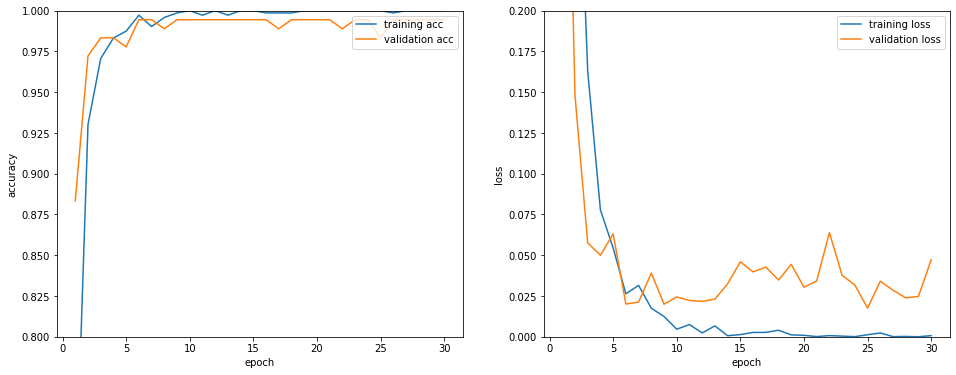

In [0]:
class_dict = {'A': 0, 'B': 1, 'C': 2, 'V': 3, 'W': 4}
num_classes = len(class_dict)
dataset_file_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/all_data_16_rh.txt"
model_save_root = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_rh/"
split_ratio = 0.8  # split ratio of training and validation data
epochs = 30     # number of training epochs.

plt.rcParams["figure.figsize"] = [16, 6]
model = train_with_val(dataset_file_path, model_save_root, split_ratio, num_classes, epochs)

The left plot shows a rather stable tendency of accuracy on both training and validation datasets (since this is not a very big dataset). But from the loss plot on the right, we can see that though the training loss keeps decreasing, the validation loss starts to oscillate after about 10 epochs, which implies the learning rate may be a little big. So I decided to make some changes on the learning rate.

### **4.2.3 Improvement on the performance**

In this part I use the multi-step learning rate scheduler, and decreased the learning rate every **milestone** epochs by a coefficient **gamma**.

Code has already been added in the custom_callback class.

Other settings are the same as before.

716 train samples
180 validation samples
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 5)                 505       
Total params: 36,305
Trainable params: 36,305
Non-trainable params: 0
_________________________________________________________________
Train on 716 samples, validate on 180 samples
Epoch 1/30
716/716 [========

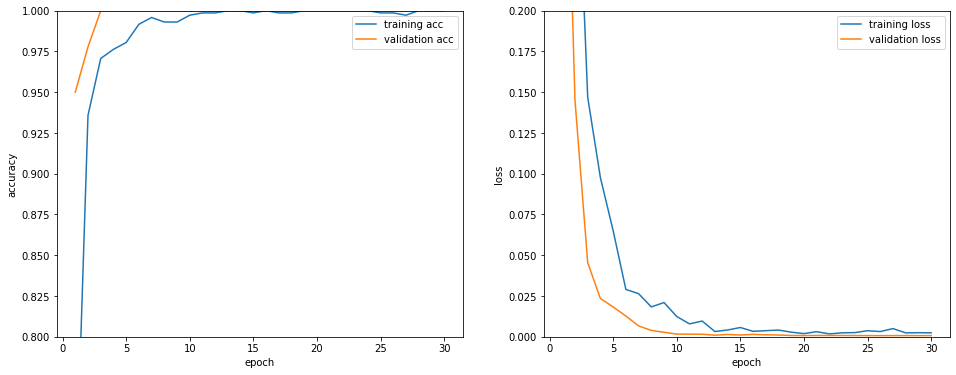

In [0]:
class_dict = {'A': 0, 'B': 1, 'C': 2, 'V': 3, 'W': 4}
num_classes = len(class_dict)
dataset_file_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/all_data_16_rh.txt"
model_save_root = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_rh/"
split_ratio = 0.8  # split ratio of training and validation data
epochs = 30     # number of training epochs.

plt.rcParams["figure.figsize"] = [16, 6]
model = train_with_val(dataset_file_path, model_save_root, split_ratio, num_classes, epochs, milestone=10, gamma=0.1)

Here I show the figures before and after changing the learning rate.

**Default learning rate scheduler:**

![default](https://drive.google.com/uc?id=1ClF48_scjcVXxJyAhs7yOjtjJRB0FGqB)

**Multi-step learning rate scheduler:** (multiply by 0.1 every 10 epochs)

![multi-step](https://drive.google.com/uc?id=1iSXSSQsE6d2eIu896sLH-YTrw7XE4rmK)

The accuracy of training and validation both approach 1, and the val_loss reduces below the train_loss, and is lower and smoother than before.

## **4.3 Real-time Testing for Gesture Recognition**

### **4.3.1 Instructions and functions**

Here I use the same App class and run it in the **test mode** by setting **TEST_PHASE=True**.

In [0]:
from keras.models import model_from_json

def test(json_path, weight_path):
    """
    The test function.
    :param json_path: the .json file to be loaded.
    :param weight_path: the .h5 file to be loaded.
    """
    # load json and create model
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_path)
    # create the application instance and use the test mode by setting TEST_PHASE=TRUE.
    app = App(SHOW_BACKPROJ=False, SAVE_DRIVE=False, TEST_PHASE=True, model=loaded_model)
    app.run()

### **4.3.2 Demo for testing**

To run the rest we need to specify the **letter_dict** as mapping from predicted categories to the represented letters (as we only train with certain letters), which is actually the counter mapping of class_dict while
 training. 

And the **model_json_path** and **model_weight_path** are the path of .json and .h5 files that are used.

The letters in my dataset are listed in letter_dict, and be careful to use your **right hand** :)

In [0]:
letter_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'V', 4: 'W'}
model_json_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_rh/model_epoch20.json"
model_weight_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_rh/model_weights_epoch20.h5"
test(model_json_path, model_weight_path)

During my testing, sometimes 'V' and 'W' are mistook because they look a little similar. And another possbile reason may be at the beginning I used my left hand during data collecting, and then I found I was doing oppositely to the gesture example. So I did a horizontal flip on all data I have collected before, and collected more data with my right hand to balance (as is stated before). The illumination may change a little bit during the process. But most of the time, the algorithm is able to give the right prediction.

### **4.3.3 Some test examples**
Examples are removed due to private information.

# **5 Transfer Learning**

In this part the pretrained vgg19 is used to extract the representations of the 224x224 hand images, and then an MLP is trained using these representations (the hand features), which indicates we transfer the features learned by the deep convolutional network vgg19 on imagenet to the representation of hand images, for our MLP training. This MLP can be quite simple, here I just used one fully connected convolutional layer with the final softmax as the output.

For convenience, previous codes that are necessary for this tast have already been copied to this part. So to see the results, just need to run the cells in this part in order.

## **5.1 Dataset Composing**

The 224x224 image are read and input into the pretrained vgg19 model. The output feature vector of 4096 dimension will be then saved in the txt file with the letter it represents, as the same format in Chapter 4, tast 6~8.

In [0]:
from google.colab import drive
drive.mount("/content/drive/")
DRIVE_MOUNTED = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
def extract_and_save_vgg_feature(img_root, save_path):
    """
    Function to input the 224x224 image into the pretrained VGG19 network and save the output
    feature into the txt file.
    :param img_root: the root directory of the saved 224x224 image.
    :param save_path: the save directory of the output txt data file.
    """
    paths_list = sorted(glob.glob(img_root + "*"))
    X = np.empty((len(paths_list), 224, 224, 3)) # input images
    Y = []  # label of the images
    for i, image_path in enumerate(paths_list):
        img = image.load_img(image_path)
        img = image.img_to_array(img)
        img = preprocess_input(img)
        X[i] = img
        letter = image_path.split('/')[-1].split('_')[0]
        Y.append(letter)

    # load the model and do the inference
    vgg_model = VGG19(weights='imagenet') # Load VGG model and weights
    model = Model(inputs=vgg_model.input, outputs=[vgg_model.get_layer("fc2").output]) # Get the fc2 layer instead of the prediction layer trained for ImageNet
    model.summary() # See our model
    output_feats = model.predict(X) # Extract features of our images. Size = (nb_images, 4096)
    
    # write to the txt file
    out_file = open(save_path, mode='a+', encoding='utf-8')
    for i in range(len(paths_list)):
        write_line = Y[i] + ',' + ','.join([str(pix) for pix in output_feats[i]]) + '\n'
        out_file.write(write_line)
    out_file.close()


img_root = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/image224x224rh/"
save_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/all_data_224_rh.txt"
extract_and_save_vgg_feature(img_root, save_path)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

The same function as in 4.2 to read data from the txt file and do the random split. (Just copy paste here)

In [0]:
def load_dataset(dataset_file_path):
    """
    A function to read the txt dataset file, shuffle the samples and compose data and labels.
    :param dataset_file_path: the saved txt file.
    :return: numpy arrays of the input data and labels.
    """
    dataset_file = open(dataset_file_path, mode='r', encoding='utf-8')
    lines = dataset_file.readlines()
    # randomly shuffle the lines in the txt file.
    random.shuffle(lines)
    samples, letters = [], []
    for line in lines:
        line_list = line.strip().split(',')
        letters.append(class_dict[line_list[0]])         # labels
        samples.append([float(pix) for pix in line_list[1:]]) # input data
    return np.array(samples), np.array(letters)


def split_train_val(samples, labels, split_ratio):
    """
    A function to split the lists of input data and labels into training and validation datasets.
    :param samples: the list of input data (numpy array of (n, 256)).
    :param labels: the list of corresponding labels of the data (numpy array of (n,)).
    :param split_ratio: the ratio of training data proportion.
    :return: the splitted training and validation data and labels.
    """
    split_idx = int(np.floor(len(labels) * split_ratio))
    data_train, label_train = samples[:split_idx], labels[:split_idx]
    data_val, label_val = samples[split_idx:], labels[split_idx:]
    return data_train, label_train, data_val, label_val

## **5.2 Training and Validation of the MLP**

The training and validation loop is the same as in 4.2, except for the sturcture of the MLP. Here I just use one fully connected layer of 4096 to 5, with the softmax activation which finally outputs the probabilities of the 5 classes.

In [0]:
def create_model_vgg(input_dim, output_classes):
    """
    The function to create an MLP model.
    :param input_dim: the dimension of the input data.
    :param output_classes: the number of classes.
    :return: the model.
    """
    model = Sequential()
    # the final dense layer with the number of classes as outputs and a softmax layer.
    model.add(Dense(output_classes, activation='softmax', input_shape=(input_dim, )))
    return model


class custom_callback(Callback):
    """
    Customized callback function to add some operations at the end of each epoch.
    The first operation is to save the model at the end of each epoch.
    The second operation is changing the learning rate using multistep strategy.
    :param save_root: the saving directory.
    :param model_name: self-defined name of the model to be saved.
    :param milestone: the epoch to decrease the learning rate by multiplying gamma.
    :param gamma: the factor to be multiplied to the current learning rate.
    :param save_epoch: the epoch interval to save the model
    """
    def __init__(self, save_root, model_name, save_epoch=1, milestone=None, gamma=None):
        super(custom_callback, self).__init__()
        self.save_root = save_root
        self.model_name = model_name
        self.milestone = milestone
        self.save_epoch = save_epoch
        if gamma == None:
            self.gamma = 0.1
        else:
            self.gamma = gamma

    def on_epoch_end(self, epoch, logs=None):
        """
        Operations to be performed at the end of each epoch.
        """
        # save the model
        if epoch % self.save_epoch == 0:
            model_json = self.model.to_json()
            with open("%s%s_epoch%d.json" % (self.save_root, self.model_name, epoch), "w+") as json_file:
                json_file.write(model_json)
            self.model.save_weights("%s%s_weights_epoch%d.h5" % (self.save_root, self.model_name, epoch))
        # check if we should change the learning rate
        if self.milestone is not None:
            if epoch % self.milestone == 0 and epoch != 0:
                lr = K.get_value(self.model.optimizer.lr)
                K.set_value(self.model.optimizer.lr, lr * self.gamma)
                print("lr changed to %.8f" % (lr * self.gamma))


def train_with_val_vgg(dataset_file_path, model_save_root, split_ratio, num_classes, epochs, save_epoch=50, milestone=None, gamma=None):
    """
    Training and Validation loop.
    :param dataset_file_path: the directory of the input txt data file.
    :param model_save_root: the base directory to save the models.
    :split_ratio: the ratio used to split training and validation datasets.
    :num_classes: the number of classes (gestures) of the data.
    :epochs: training epochs.
    """
    # load, shuffle and split the datasets.
    samples, labels = load_dataset(dataset_file_path)
    data_train, label_train, data_val, label_val = split_train_val(samples, labels, split_ratio)

    # numerical values process of input data (map to 0.0~1.0) and labels (to one hot labels).
    data_train = data_train.astype('float32') / 255.0
    data_val = data_val.astype('float32') / 255.0
    label_train = keras.utils.to_categorical(label_train, num_classes)
    label_val = keras.utils.to_categorical(label_val, num_classes)
    print(data_train.shape[0], 'train samples')
    print(data_val.shape[0], 'validation samples')

    # create the model.
    model = create_model_vgg(4096, num_classes)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    
    if not os.path.exists(model_save_root):
        os.makedirs(model_save_root)

    # training and validation of the model.
    history = model.fit(data_train, label_train,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(data_val, label_val),
                        callbacks=[custom_callback(model_save_root, "model", save_epoch, milestone, gamma)])
    
    # fianl evaluatoin
    score = model.evaluate(data_val, label_val, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])

    # plot the train-val loss and accuracy curves
    label_x = np.arange(1, epochs+1, 1)
    plt.figure()
    plt.plot([1, 2])
    plt.subplot(121)
    plt.plot(label_x, history.history['accuracy'], label='training acc')
    plt.plot(label_x, history.history['val_accuracy'], label='validation acc')
    plt.ylim(0.8, 1.0)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(label_x, history.history['loss'], label='training loss')
    plt.plot(label_x, history.history['val_loss'], label='validation loss')
    # plt.ylim(0, 0.2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

    return model

## **5.3 Demo for training and validation**


716 train samples
180 validation samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 20485     
Total params: 20,485
Trainable params: 20,485
Non-trainable params: 0
_________________________________________________________________
Train on 716 samples, validate on 180 samples
Epoch 1/500
716/716 [==============================] - 0s 408us/step - loss: 1.5653 - accuracy: 0.6732 - val_loss: 1.5294 - val_accuracy: 0.9611
Epoch 2/500
716/716 [==============================] - 0s 74us/step - loss: 1.5020 - accuracy: 0.9413 - val_loss: 1.4737 - val_accuracy: 0.9778
Epoch 3/500
716/716 [==============================] - 0s 83us/step - loss: 1.4472 - accuracy: 0.9595 - val_loss: 1.4205 - val_accuracy: 0.9556
Epoch 4/500
716/716 [==============================] - 0s 82us/step - loss: 1.3944 - accuracy: 0.9469 - val_loss: 1.3697 - v

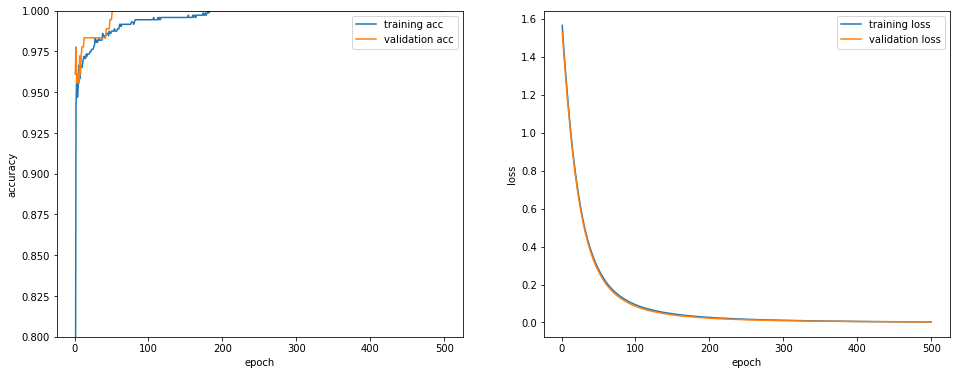

In [0]:
class_dict = {'A': 0, 'B': 1, 'C': 2, 'V': 3, 'W': 4}
num_classes = len(class_dict)
dataset_file_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/detect_hands/all_data_224_rh.txt"
model_save_root = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_224_rh/"
split_ratio = 0.8  # split ratio of training and validation data
epochs = 500     # number of training epochs.

plt.rcParams["figure.figsize"] = [16, 6]
model = train_with_val_vgg(dataset_file_path, model_save_root, split_ratio, num_classes, epochs)

![](https://drive.google.com/uc?id=1-hT62qVrzDtUbYd2CzqvVJEmF4sbwh03)

Improvements on the training & validation accuracy and loss values, compared to purely using the MLP model with 256*1 input features. Besides, the training process is easier as it only contains one layer.

## **5.4 Demo for Testing**

In [0]:
def test_vgg(json_path, weight_path):
    """
    The test function.
    :param json_path: the .json file to be loaded.
    :param weight_path: the .h5 file to be loaded.
    """
    # load json and create model
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weight_path)
    # create the application instance and use the test mode by setting TEST_PHASE=TRUE.
    app = App(SHOW_BACKPROJ=False, SAVE_DRIVE=False, TEST_PHASE=True, TEST_VGG=True, model=loaded_model)
    app.run()

In [0]:
letter_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'V', 4: 'W'}
model_json_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_224_rh/model_epoch150.json"
model_weight_path = "/content/drive/My Drive/CV/CV_projects_Rui_ZHANG/ckpt_224_rh/model_weights_epoch150.h5"
test_vgg(model_json_path, model_weight_path)

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

Examples are removed due to private information.